### **GTSRB - German Traffic Sign Recognition Benchmark - PyTorch**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import time
import copy
import zipfile
import shutil

import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, random_split




In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
#dataset drive path

dataset_path = "/content/drive/MyDrive/trafficsign_dataset/archive.zip"
os.path.exists(dataset_path)


True

In [5]:
#extract dataset

zip_path = "/content/drive/MyDrive/trafficsign_dataset/archive.zip"
extract_path = "/content/trafficsign_dataset"

# Check if ZIP exists
if not os.path.exists(zip_path):
    raise FileNotFoundError(f"ZIP file not found at {zip_path}")

# Create extraction folder if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")
print("Contents:", os.listdir(extract_path))


Dataset extracted successfully!
Contents: ['Test', 'train', 'meta', 'Meta', 'Train.csv', 'Train', 'test', 'Meta.csv', 'Test.csv']


In [6]:
#contents of dataset
train_path = "/content/trafficsign_dataset/Train"
test_path  = "/content/trafficsign_dataset/Test"

print("Contents of dataset folder:", os.listdir('/content/trafficsign_dataset'))
print("Contents of Train folder:", os.listdir(train_path))
print("Contents of Test folder:", os.listdir(test_path))


Contents of dataset folder: ['Test', 'train', 'meta', 'Meta', 'Train.csv', 'Train', 'test', 'Meta.csv', 'Test.csv']
Contents of Train folder: ['12', '9', '36', '8', '3', '29', '23', '21', '35', '6', '30', '37', '15', '39', '7', '5', '24', '14', '42', '4', '38', '28', '33', '34', '27', '10', '25', '17', '41', '1', '20', '11', '40', '31', '19', '13', '2', '32', '22', '18', '16', '26', '0']
Contents of Test folder: ['11668.png', '11309.png', '08045.png', '10876.png', '09066.png', '03948.png', '04388.png', '10730.png', '12566.png', '00353.png', '05743.png', '00225.png', '02058.png', '04659.png', '08183.png', '02565.png', '10516.png', '05126.png', '11222.png', '05395.png', '06017.png', '01964.png', '04555.png', '12556.png', '10222.png', '11559.png', '10985.png', '06618.png', '09571.png', '00884.png', '05842.png', '05025.png', '08095.png', '09622.png', '03092.png', '07191.png', '04286.png', '02591.png', '01874.png', '08455.png', '00171.png', '11658.png', '05438.png', '04843.png', '04840.png'

In [7]:
#check to see that Test folder contain images not classes -> error for ImageFolder
# Path to your Test.csv
csv_file = "/content/trafficsign_dataset/Test.csv"

# Load the CSV
df = pd.read_csv(csv_file)

# Display the first few rows
print(df.head())

# Display column names
print("Columns in CSV:", df.columns.tolist())


   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0     53      54       6       5      48      49       16  Test/00000.png
1     42      45       5       5      36      40        1  Test/00001.png
2     48      52       6       6      43      47       38  Test/00002.png
3     27      29       5       5      22      24       33  Test/00003.png
4     60      57       5       5      55      52       11  Test/00004.png
Columns in CSV: ['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId', 'Path']


In [8]:
#convert Test images to their classes

# Paths
test_folder = "/content/trafficsign_dataset/Test"
csv_file = "/content/trafficsign_dataset/Test.csv"

# Load CSV
df = pd.read_csv(csv_file)

# Create class subfolders and move images
for _, row in df.iterrows():
    filename = os.path.basename(row['Path'])  # extract filename from Path
    class_label = str(row['ClassId'])
    class_folder = os.path.join(test_folder, class_label)

    # Create class folder if it doesn't exist
    os.makedirs(class_folder, exist_ok=True)

    # Move the image into the class folder
    src = os.path.join(test_folder, filename)
    dst = os.path.join(class_folder, filename)

    if os.path.exists(src):
        shutil.move(src, dst)

print("Test folder fixed: images organized into class subfolders.")


Test folder fixed: images organized into class subfolders.


In [9]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

transform_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

transform_test = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

# FIXED VERSION: Forces correct label order 0 to 42
class GTSRBFixed(datasets.ImageFolder):
    def find_classes(self, directory):
        classes = sorted([d.name for d in os.scandir(directory) if d.is_dir()])
        classes.sort(key=lambda x: int(x))  # Critical: sort by number, not string
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

# Now load with fixed class ordering
train_dataset = GTSRBFixed(train_path, transform=transform_train)
test_dataset  = GTSRBFixed(test_path,      transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,  num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

print("Classes now correctly ordered:")
print(train_dataset.classes[:10])   # Should show ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
print("Total classes:", len(train_dataset.classes))  # Must be 43

Classes now correctly ordered:
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Total classes: 43


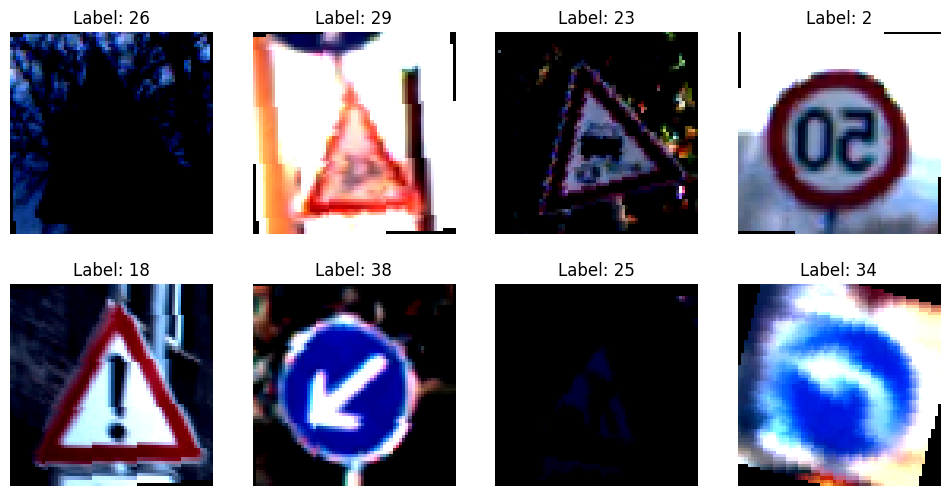

In [10]:
#sample batch
images, labels = next(iter(train_loader))

plt.figure(figsize=(12, 6))
for i in range(8):
    img = images[i].permute(1, 2, 0) * 0.5 + 0.5  # unnormalize
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(f"Label: {labels[i].item()}")
    plt.axis("off")
plt.show()


In [12]:

#	Cause (most common first)	How to check	Fix (copy-paste ready)
print(train_dataset.classes[:10])
print(train_dataset.class_to_idx)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, '11': 11, '12': 12, '13': 13, '14': 14, '15': 15, '16': 16, '17': 17, '18': 18, '19': 19, '20': 20, '21': 21, '22': 22, '23': 23, '24': 24, '25': 25, '26': 26, '27': 27, '28': 28, '29': 29, '30': 30, '31': 31, '32': 32, '33': 33, '34': 34, '35': 35, '36': 36, '37': 37, '38': 38, '39': 39, '40': 40, '41': 41, '42': 42}


In [32]:
classeslabels_fetched = {
    0:'Speed limit (20km/h)',
    1:'Speed limit (30km/h)',
    2:'Speed limit (50km/h)',
    3:'Speed limit (60km/h)',
    4:'Speed limit (70km/h)',
    5:'Speed limit (80km/h)',
    6:'End of speed limit (80km/h)',
    7:'Speed limit (100km/h)',
    8:'Speed limit (120km/h)',
    9:'No passing',
    10:'No passing veh over 3.5 tons',
    11:'Right-of-way at intersection',
    12:'Priority road',
    13:'Yield',
    14:'Stop',
    15:'No vehicles',
    16:'Veh > 3.5 tons prohibited',
    17:'No entry',
    18:'General caution',
    19:'Dangerous curve left',
    20:'Dangerous curve right',
    21:'Double curve',
    22:'Bumpy road',
    23:'Slippery road',
    24:'Road narrows on the right',
    25:'Road work',
    26:'Traffic signals',
    27:'Pedestrians',
    28:'Children crossing',
    29:'Bicycles crossing',
    30:'Beware of ice/snow',
    31:'Wild animals crossing',
    32:'End speed + passing limits',
    33:'Turn right ahead',
    34:'Turn left ahead',
    35:'Ahead only',
    36:'Go straight or right',
    37:'Go straight or left',
    38:'Keep right',
    39:'Keep left',
    40:'Roundabout mandatory',
    41:'End of no passing',
    42:'End no passing veh > 3.5 tons'
}

# **CNN Model**

In [13]:
#CNN Model

class TrafficSignCNNEnhanced(nn.Module):
    def __init__(self, num_classes):
        super(TrafficSignCNNEnhanced, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),        # 64x64 -> 32x32


            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2),        # 32x32 -> 16x16


            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2),        # 16x16 -> 8x8


            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2,2),        # 8x8 -> 4x4
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*4*4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


### **Transfer Learning using ResNet18, adam Optimizer**

In [14]:
import os
train_path = "/content/trafficsign_dataset/Train"
classes = os.listdir(train_path)
classes = [c for c in classes if os.path.isdir(os.path.join(train_path, c))]

print("Number of classes:", len(classes))
print("Classes:", classes)

Number of classes: 43
Classes: ['12', '9', '36', '8', '3', '29', '23', '21', '35', '6', '30', '37', '15', '39', '7', '5', '24', '14', '42', '4', '38', '28', '33', '34', '27', '10', '25', '17', '41', '1', '20', '11', '40', '31', '19', '13', '2', '32', '22', '18', '16', '26', '0']


In [15]:
def resnet_train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=25):
    """
    Trains and evaluates the model, incorporating a learning rate scheduler
    that steps based on the test set loss (used as validation loss).
    """
    since = time.time()
    device = next(model.parameters()).device # Get the device the model is on

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    print(f"Starting training on device: {device}")

    # Store results for plotting later
    history = {'train_loss': [], 'test_loss': [], 'test_acc': []}

    for epoch in range(num_epochs):
        print('\nEpoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # -------------------
        # --- Training Phase ---
        # -------------------
        model.train()
        running_loss = 0.0
        running_corrects = 0
        train_size = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            train_size += inputs.size(0)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / train_size
        epoch_acc = running_corrects.double() / train_size

        history['train_loss'].append(epoch_loss)
        print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        # -------------------
        # --- Evaluation Phase (using test_loader as validation) ---
        # -------------------
        model.eval()
        test_running_loss = 0.0
        test_running_corrects = 0
        test_size = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                test_size += inputs.size(0)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                test_running_loss += loss.item() * inputs.size(0)
                test_running_corrects += torch.sum(preds == labels.data)

        test_epoch_loss = test_running_loss / test_size
        test_epoch_acc = test_running_corrects.double() / test_size

        history['test_loss'].append(test_epoch_loss)
        history['test_acc'].append(test_epoch_acc.item())

        print('Test Loss: {:.4f} Acc: {:.4f}'.format(test_epoch_loss, test_epoch_acc))

        # --- Scheduler Step ---
        # Step the scheduler based on the Test Loss (used as validation metric)
        scheduler.step(test_epoch_loss)
        print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")


        # Deep copy the model if the test accuracy is the best so far
        if test_epoch_acc > best_acc:
            best_acc = test_epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('\nTraining complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Test Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [ ]:
resnet_model = models.resnet18(pretrained=True).to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
num_features = resnet_model.fc.in_features

In [ ]:
for param in resnet_model.parameters():
    param.requires_grad = True

In [ ]:
resnet_model.fc = nn.Linear(num_features, 43).to(device)
# hena el 43 is number of traffic signs classes
resnet_model.fc.requires_grad = True

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    resnet_model.parameters(), lr=0.0003
    )

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,       # reduce LR by 10x
    patience=3,       # wait 3 epochs with no improvement
)

In [ ]:
# def resnet_train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=25):

resnet_model, history = resnet_train_model(resnet_model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=20)

In [ ]:
torch.save(resnet_model.state_dict(), "resnet_final.pth") #saving weights to load the model later without retraining.

##Training Results RESNET18


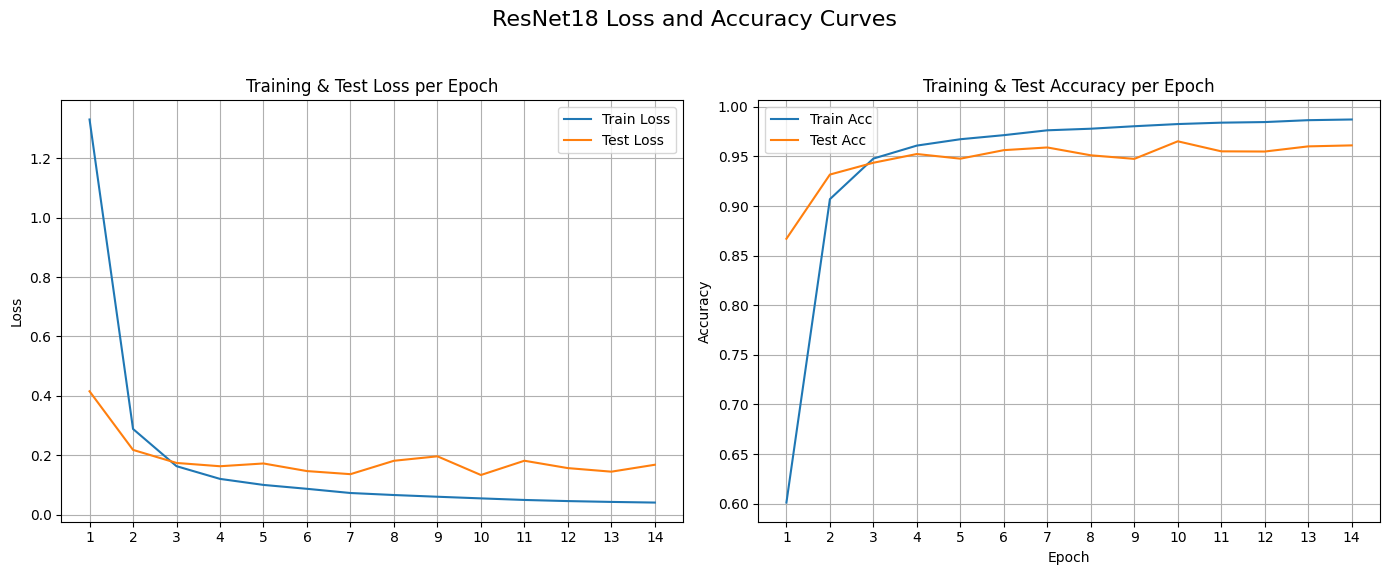

In [13]:
import matplotlib.pyplot as plt

# Data extracted from new logs (14 Epochs)
epochs = list(range(1, 15))

train_loss = [1.3303, 0.2885, 0.1632, 0.1204, 0.1001, 0.0870, 0.0729, 0.0661, 0.0603, 0.0548, 0.0495, 0.0457, 0.0429, 0.0407]
test_loss  = [0.4153, 0.2180, 0.1741, 0.1630, 0.1723, 0.1467, 0.1363, 0.1814, 0.1964, 0.1335, 0.1815, 0.1567, 0.1447, 0.1680]

train_acc  = [0.6011, 0.9069, 0.9478, 0.9609, 0.9673, 0.9714, 0.9763, 0.9779, 0.9804, 0.9826, 0.9840, 0.9846, 0.9865, 0.9872]
test_acc   = [0.8670, 0.9317, 0.9436, 0.9524, 0.9477, 0.9563, 0.9590, 0.9511, 0.9475, 0.9652, 0.9551, 0.9549, 0.9601, 0.9611]


# Create a figure with two subplots (2 rows, 1 column)
fig, (ax1, ax2) = plt.subplots( 1,2, figsize=(14, 6))
fig.suptitle('ResNet18 Loss and Accuracy Curves', fontsize=16)

# --- Subplot 1: Loss ---
ax1.plot(epochs, train_loss, label="Train Loss")
ax1.plot(epochs, test_loss, label="Test Loss")
ax1.set_ylabel("Loss")
ax1.set_title("Training & Test Loss per Epoch")
ax1.legend()
ax1.grid(True)
ax1.set_xticks(epochs)

# --- Subplot 2: Accuracy ---
ax2.plot(epochs, train_acc, label="Train Acc")
ax2.plot(epochs, test_acc, label="Test Acc")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Training & Test Accuracy per Epoch")
ax2.legend()
ax2.grid(True)
ax2.set_xticks(epochs)

# Adjust layout to prevent titles and labels from overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##Training Results EfficientNet-B0

In [16]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

In [28]:
weights = EfficientNet_B0_Weights.DEFAULT
efficientnet_model_trained = efficientnet_b0(weights=train_loader)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
auto_transforms = weights.transforms()

print("Preprocessing steps:", auto_transforms)

Preprocessing steps: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [ ]:
efficientnet_model_trained = get_efficientnet_model(num_classes=43)
optimizer = torch.optim.Adam(efficientnet_model_trained.parameters(), lr=0.001)

In [ ]:
def get_efficientnet_model(num_classes):

    print("Loading EfficientNet-B0 with ImageNet weights...")
    model = efficientnet_b0(weights=weights)

    for param in model.features.parameters():
        param.requires_grad = False

    # Correctly access in_features from the Linear layer within the Sequential classifier
    in_features = model.classifier[1].in_features


    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=in_features, out_features=num_classes)
    )

    return model.to(device)

In [ ]:
efficientnet_model_trained = get_efficientnet_model(num_classes=43)
optimizer = torch.optim.Adam(efficientnet_model_trained.parameters(), lr=0.001)

Loading EfficientNet-B0 with ImageNet weights...


In [ ]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,       # reduce LR by 10x
    patience=3,       # wait 3 epochs with no improvement
)

Starting training on device: cuda:0

Epoch 1/20
----------
Train Loss: 1.7876 Acc: 0.4961
Test Loss: 1.7082 Acc: 0.4925
Current LR: 0.001000

Epoch 2/20
----------
Train Loss: 1.3080 Acc: 0.6034
Test Loss: 1.6849 Acc: 0.5059
Current LR: 0.001000

Epoch 3/20
----------
Train Loss: 1.2170 Acc: 0.6225
Test Loss: 1.7079 Acc: 0.5058
Current LR: 0.001000

Epoch 4/20
----------
Train Loss: 1.1773 Acc: 0.6322
Test Loss: 1.7045 Acc: 0.5074
Current LR: 0.001000

Epoch 5/20
----------
Train Loss: 1.1642 Acc: 0.6345
Test Loss: 1.7394 Acc: 0.5020
Current LR: 0.001000

Epoch 6/20
----------
Train Loss: 1.1613 Acc: 0.6331
Test Loss: 1.7335 Acc: 0.5042
Current LR: 0.000100

Epoch 7/20
----------
Train Loss: 1.1058 Acc: 0.6511
Test Loss: 1.7389 Acc: 0.5061
Current LR: 0.000100

Epoch 8/20
----------
Train Loss: 1.1058 Acc: 0.6495
Test Loss: 1.7235 Acc: 0.5035
Current LR: 0.000100

Epoch 9/20
----------
Train Loss: 1.0918 Acc: 0.6537
Test Loss: 1.6970 Acc: 0.5184
Current LR: 0.000100

Epoch 10/20
------

In [ ]:
efficientnet_model_trained= resnet_train_model(efficientnet_model_trained, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=10)

In [ ]:
torch.save(efficientnet_model_trained.state_dict(), "efficientnet_finalmodel.pth")

##Performance Evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# predictions on test set
resnet_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = resnet_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

##CNN Model Training

In [ ]:
modelcnn = TrafficSignCNNEnhanced(num_classes=43).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelcnn.parameters(), lr=0.0003)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
)

modelcnn, history2 = resnet_train_model(modelcnn, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=20)

torch.save(modelcnn.state_dict(), "custom_cnn_final.pth")

##CNN Model Results

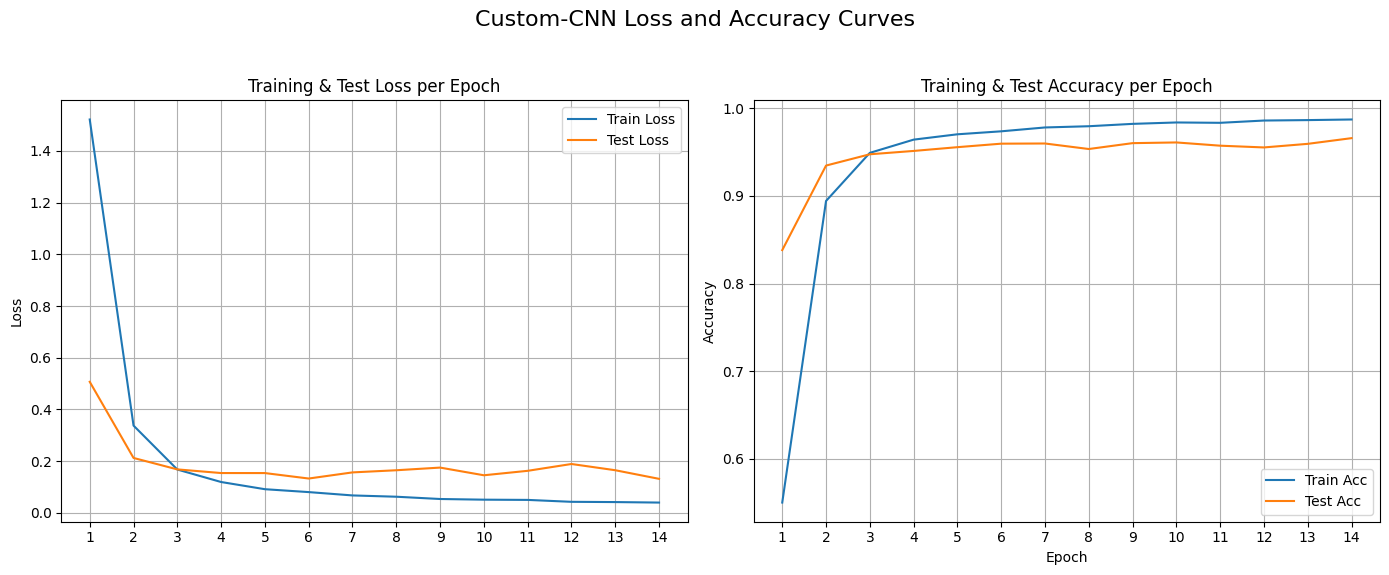

In [14]:
import matplotlib.pyplot as plt

epochs = list(range(1, 15))

train_loss = [1.5218, 0.3378, 0.1678, 0.1195, 0.0917, 0.0805, 0.0676, 0.0626, 0.0538, 0.0512, 0.0503, 0.0429, 0.0419, 0.0400]
test_loss  = [0.5071, 0.2126, 0.1683, 0.1542, 0.1541, 0.1330, 0.1567, 0.1650, 0.1753, 0.1456, 0.1628, 0.1892, 0.1651, 0.1318]

train_acc  = [0.5501, 0.8943, 0.9492, 0.9643, 0.9704, 0.9738, 0.9782, 0.9796, 0.9823, 0.9839, 0.9835, 0.9861, 0.9866, 0.9873]
test_acc   = [0.8382, 0.9347, 0.9476, 0.9514, 0.9557, 0.9597, 0.9599, 0.9536, 0.9603, 0.9611, 0.9574, 0.9554, 0.9595, 0.9660]

import matplotlib.pyplot as plt

# Data extracted from previous logs (14 Epochs)
epochs = list(range(1, 15))

train_loss = [1.5218, 0.3378, 0.1678, 0.1195, 0.0917, 0.0805, 0.0676, 0.0626, 0.0538, 0.0512, 0.0503, 0.0429, 0.0419, 0.0400]
test_loss  = [0.5071, 0.2126, 0.1683, 0.1542, 0.1541, 0.1330, 0.1567, 0.1650, 0.1753, 0.1456, 0.1628, 0.1892, 0.1651, 0.1318]

train_acc  = [0.5501, 0.8943, 0.9492, 0.9643, 0.9704, 0.9738, 0.9782, 0.9796, 0.9823, 0.9839, 0.9835, 0.9861, 0.9866, 0.9873]
test_acc   = [0.8382, 0.9347, 0.9476, 0.9514, 0.9557, 0.9597, 0.9599, 0.9536, 0.9603, 0.9611, 0.9574, 0.9554, 0.9595, 0.9660]


fig, (ax1, ax2) = plt.subplots( 1,2, figsize=(14, 6))
fig.suptitle('Custom-CNN Loss and Accuracy Curves', fontsize=16)

# --- Subplot 1: Loss ---
ax1.plot(epochs, train_loss, label="Train Loss")
ax1.plot(epochs, test_loss, label="Test Loss")
ax1.set_ylabel("Loss")
ax1.set_title("Training & Test Loss per Epoch")
ax1.legend()
ax1.grid(True)
ax1.set_xticks(epochs)

# --- Subplot 2: Accuracy ---
ax2.plot(epochs, train_acc, label="Train Acc")
ax2.plot(epochs, test_acc, label="Test Acc")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Training & Test Accuracy per Epoch")
ax2.legend()
ax2.grid(True)
ax2.set_xticks(epochs)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [36]:
import torch
import pandas as pd
from PIL import Image

def load_class_name_mapcnn(dataset, meta_csv_path="/content/trafficsign_dataset/Meta.csv"):
    """Loads class names from Meta.csv if available; otherwise uses generic class names."""
# /content/trafficsign_dataset/Meta.csv
    # Convert class names to sorted numeric list
    class_ids = sorted([int(c) for c in dataset.classes])

    # Try loading Meta.csv
    try:
        meta_df = pd.read_csv(meta_csv_path)
        if 'ClassId' in meta_df.columns and 'SignName' in meta_df.columns:
            print("Loaded: ClassId \u2192 SignName mapping")
            return {row.ClassId: row.SignName for _, row in meta_df.iterrows()}
        else:
            print("Meta.csv found, but missing 'ClassId' or 'SignName' \u2192 Using generic names")
    except:
        print("Meta.csv not found \u2192 Using generic names")

    # Fallback
    return {cid: f"Class {cid}" for cid in class_ids}



In [ ]:
def predict_image_classcnn(image_path, model, transform, dataset, device='cuda'):
          """
          Predicts the human-readable class name of an image with CORRECT CLASS MAPPING.
          """
          class_id_to_name_map = load_class_name_mapcnn(dataset)

          model_class_ids_str_list = dataset.classes


          image = Image.open(image_path).convert("RGB")
          input_tensor = transform(image).unsqueeze(0).to(device)

          model = model.to(device)
          model.eval()

          with torch.no_grad():
            output = model(input_tensor)
            probs = torch.nn.functional.softmax(output[0], dim=0)
            pred_index = torch.argmax(probs).item()

          pred_class_id_str = model_class_ids_str_list[pred_index]

          pred_class_id_int = int(pred_class_id_str)
          return class_id_to_name_map.get(pred_class_id_int, f"Class {pred_class_id_int}")

In [ ]:
result_cnn = predict_image_classcnn(
    image_path="/content/noover.jpg",
    model=modelcnn,
    transform=transform_test,
    dataset=train_dataset, # Use train_dataset for class info
    device='cuda'
)

print("Predicted by CNN:", result_cnn)